In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
df = pd.read_csv('data.csv')
print(df.shape)
df.head()

(195, 24)


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [3]:
df.rename(columns={"status": "target"}, inplace=True)
df = df.drop(columns="name", axis=1)
print('After preprocessing:', df.shape)
df.head()

After preprocessing: (195, 23)


,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,target,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [4]:
y = df['target'].astype(int)
X = df.drop(columns=['target'])
feature_names_full = X.columns.tolist()
print('Initial features:', len(feature_names_full))
print('Feature names:', feature_names_full)

Initial features: 22
Feature names: ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [5]:
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print('Train/Test shapes:', X_train_full.shape, X_test_full.shape)

Train/Test shapes: (156, 22) (39, 22)


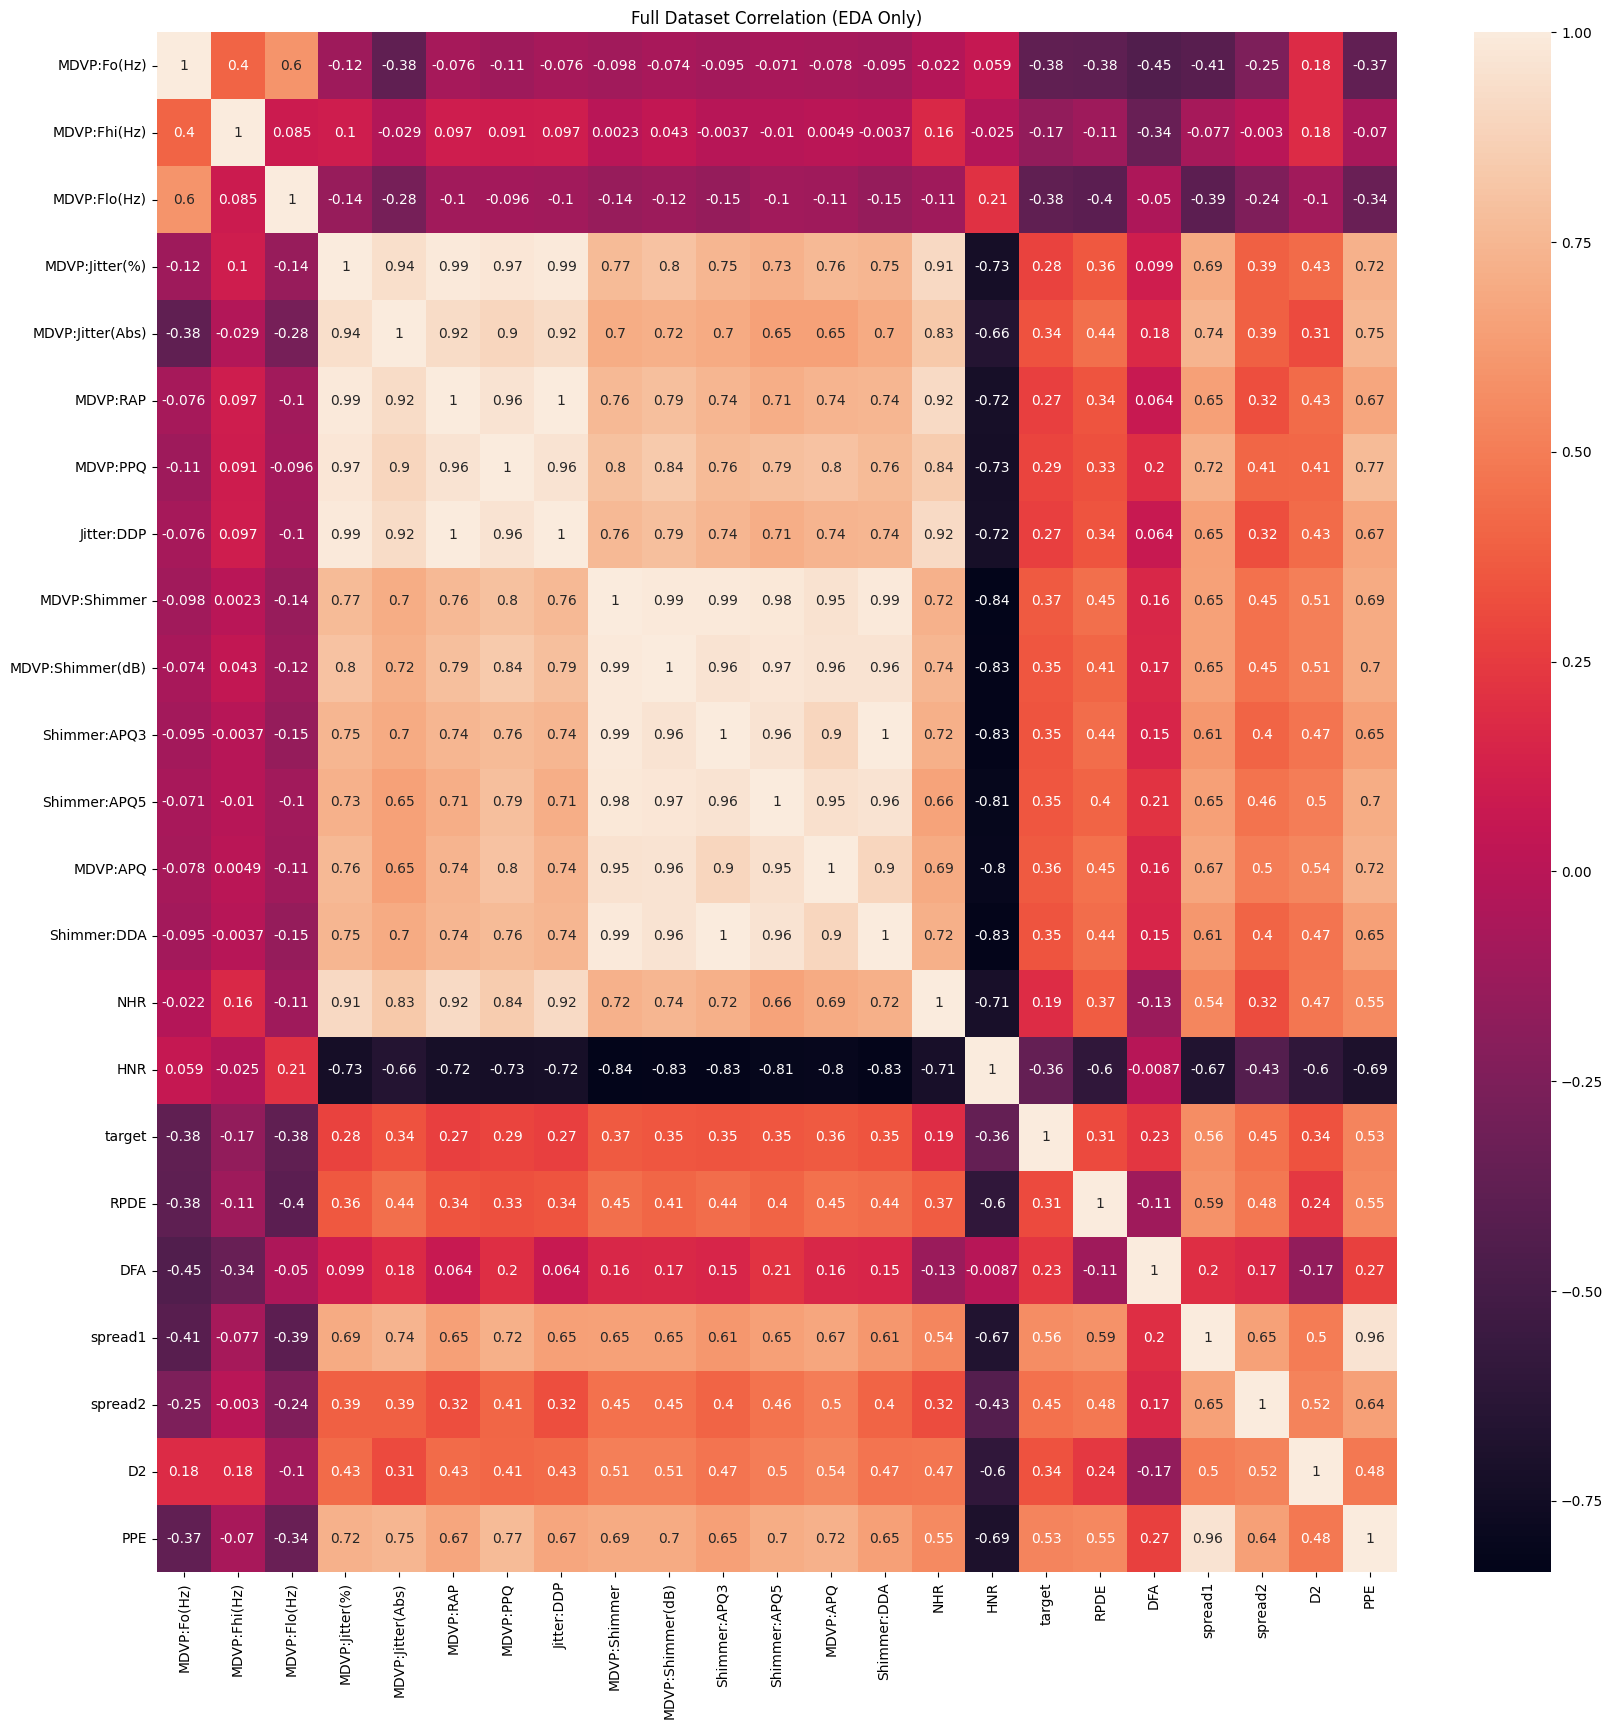

In [6]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True,fmt=".2g")
plt.title('Full Dataset Correlation (EDA Only)')
plt.show()

In [7]:
train_df = X_train_full.copy()
train_df['target'] = y_train.values

# Calculate correlation matrix on training data only
corr_matrix = train_df.corr()
corr_row = corr_matrix.loc["target"]
corr_row_rounded = [round(element, 2) for element in corr_row]

In [8]:
unique_corr_values = []
selected_features = []
seen_correlations = set()

for i, corr_val in enumerate(corr_row_rounded):
    if corr_val not in seen_correlations and corr_matrix.columns[i] != 'target':
        unique_corr_values.append(corr_val)
        selected_features.append(corr_matrix.columns[i])
        seen_correlations.add(corr_val)

print('Unique correlation values:', len(unique_corr_values))
print('Selected features (first occurrence of each correlation):', len(selected_features))
print('Selected features:', selected_features)

Unique correlation values: 16
Selected features (first occurrence of each correlation): 16
Selected features: ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'MDVP:APQ', 'NHR', 'HNR', 'DFA', 'spread1', 'spread2', 'PPE']


In [9]:
X_train = X_train_full[selected_features].copy()
X_test = X_test_full[selected_features].copy()
print('Final shapes:', X_train.shape, X_test.shape)

Final shapes: (156, 16) (39, 16)


In [10]:
dropped_features = [f for f in feature_names_full if f not in selected_features]
print('Dropped features (duplicate correlations):', len(dropped_features))
print('Dropped:', dropped_features)

Dropped features (duplicate correlations): 6
Dropped: ['Jitter:DDP', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:DDA', 'RPDE', 'D2']


In [11]:
def eval_model(name, model, Xtr, Xte, ytr, yte):
    return {
        'model': name,
        'train_acc': accuracy_score(ytr, model.predict(Xtr)),
        'test_acc': accuracy_score(yte, model.predict(Xte))
    }

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

In [14]:
svm_param_grid = [
    {'svc__kernel': ['linear'], 'svc__C': [0.1, 1, 10, 100], 'svc__probability':[True]},
    {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10, 100], 'svc__gamma': ['scale','auto'], 'svc__probability':[True]}
]

svm_grid = GridSearchCV(
    svm_pipe, svm_param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=0
)
svm_grid.fit(X_train, y_train)
print('Best SVM Params:', svm_grid.best_params_)
print('Best CV Accuracy:', round(svm_grid.best_score_,4))
best_svm = svm_grid.best_estimator_

Best SVM Params: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf', 'svc__probability': True}
Best CV Accuracy: 0.8911


In [15]:
# Logistic Regression
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=500, random_state=42))
])
lr_params = {
    'lr__C': [0.1,1,10],
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs']
}
lr_grid = GridSearchCV(lr_pipe, lr_params, scoring='accuracy', cv=cv, n_jobs=-1)
lr_grid.fit(X_train, y_train)
print('Best LR Params:', lr_grid.best_params_)
best_lr = lr_grid.best_estimator_

Best LR Params: {'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}


In [16]:
# Decision Tree
dt_pipe = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42))
])
dt_params = {
    'dt__max_depth': [None, 3, 5, 7, 9],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4]
}
dt_grid = GridSearchCV(dt_pipe, dt_params, scoring='accuracy', cv=cv, n_jobs=-1)
dt_grid.fit(X_train, y_train)
print('Best DT Params:', dt_grid.best_params_)
best_dt = dt_grid.best_estimator_

Best DT Params: {'dt__max_depth': 5, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 5}


In [17]:
# Random Forest
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
rf_params = {
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(rf_pipe, rf_params, scoring='accuracy', cv=cv, n_jobs=-1)
rf_grid.fit(X_train, y_train)
print('Best RF Params:', rf_grid.best_params_)
best_rf = rf_grid.best_estimator_

Best RF Params: {'rf__max_depth': 5, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}


In [18]:
results = []
for name, mdl in [
    ('SVM', best_svm),
    ('LogReg', best_lr),
    ('DecisionTree', best_dt),
    ('RandomForest', best_rf)
]:
    res = eval_model(name, mdl, X_train, X_test, y_train, y_test)
    results.append(res)

results_df = pd.DataFrame(results)
print('\nModel Comparison:')
print(results_df)


Model Comparison:
          model  train_acc  test_acc
0           SVM   0.974359  0.897436
1        LogReg   0.865385  0.923077
2  DecisionTree   0.993590  0.794872
3  RandomForest   0.974359  0.923077


In [19]:
# Pick best by test accuracy
results_sorted = sorted(results, key=lambda d: d['test_acc'], reverse=True)
best_name = results_sorted[0]['model']
print('Chosen final model:', best_name)

model_map = {
    'SVM': best_svm,
    'LogReg': best_lr,
    'DecisionTree': best_dt,
    'RandomForest': best_rf
}
final_pipeline = model_map[best_name]

Chosen final model: LogReg



Classification Report (Test):
              precision    recall  f1-score   support

     Healthy       0.89      0.80      0.84        10
  Parkinsons       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39



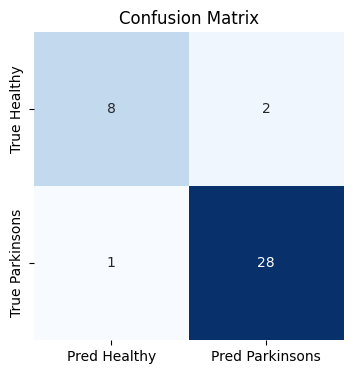

In [20]:
y_pred = final_pipeline.predict(X_test)
print('\nClassification Report (Test):')
print(classification_report(y_test, y_pred, target_names=['Healthy','Parkinsons']))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Healthy','Pred Parkinsons'], yticklabels=['True Healthy','True Parkinsons'])
plt.title('Confusion Matrix')
plt.show()

In [21]:
filename = 'parkinsons.sav'
with open(filename, 'wb') as f:
    pickle.dump(final_pipeline, f)
print('Saved model to', filename)

# Save metadata
meta = {
  'model_file': 'parkinsons.sav',
  'final_model_type': best_name,
  'selected_features': selected_features,
  'dropped_features': dropped_features,
  'all_features_original_order': feature_names_full,
  'feature_selection_method': 'unique_correlation_values',
  'target_mapping': {'0':'Healthy','1':'Parkinsons'},
  'positive_class': 1
}
with open('parkinsons_metadata.json','w') as f:
    json.dump(meta, f, indent=2)
print('Metadata saved: parkinsons_metadata.json')

Saved model to parkinsons.sav
Metadata saved: parkinsons_metadata.json
